In [28]:
import numpy as np
import pylab as plt
import sys
sys.path.insert(0, '../..')

from torch.utils.data import Dataset
from models.resnet import train_one_epoch, evaluate

import time
import csv
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

In [29]:
class AnimalDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = Path(root)
        self.train = train
        self.ann_file = self.root / 'labels.csv'
        self.transform = transform

        # Read annotation file
        t = time.time()
        self.labels = []
        self.class_names = []
        self.obsids_to_classids = {}
        self.obsids_to_classnames = {}
        self.classid_to_classname = {}
        with open(self.ann_file, 'r') as f:
            data = csv.DictReader(f)
            for d in data:
                obs_id = d['observation_id']
                class_id = int(d['taxon_id'])
                class_name = d['taxon_name']
                self.obsids_to_classnames[obs_id] = class_name
                self.obsids_to_classids[obs_id] = class_id
                self.classid_to_classname[class_id] = class_name
        print('Took {:.2f}s to load annotations.'.format(time.time()-t))


        # Load images
        t = time.time()
        self.img_ids = []
        self.img_paths = []
        for path in self.root.glob('*'):
            if not path.is_dir():
                continue
            for img_path in path.glob('*.jpeg'):
                self.img_paths.append(img_path)
                self.img_ids.append(img_path.stem)
        print('Took {:.2f}s to load img paths.'.format(time.time()-t))


        self.data = self.img_paths
        self.original_targets = [self.obsids_to_classids[img_id] for img_id in self.img_ids]
        target_mapping  = {orig_target: i for i, orig_target in enumerate(np.unique(self.original_targets))}
        self.targets = [target_mapping[t] for t in self.original_targets]

        assert len(self.data) == len(self.targets), 'Data and targets differ in length.'


    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path)
        target = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, target


    def __len__(self):
        return len(self.data)

dataset = AnimalDataset(root='/home/denis/Documents/datasets/animals')

Took 0.02s to load annotations.
Took 0.03s to load img paths.


In [42]:
import sys
sys.path.insert(0, '../')
from torchvision import transforms
from torch.utils.data import Subset

def to_rgb(x):
    if x.size(0) != 3:
        x = x.repeat(3, 1, 1)
    return x


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(to_rgb)
])
dataset = AnimalDataset(root='/media/denis/ba129a73-e0ac-4969-93c6-8ea5a4f5444f/datasets/animals', transform=transform)


Took 0.02s to load annotations.
Took 0.15s to load img paths.


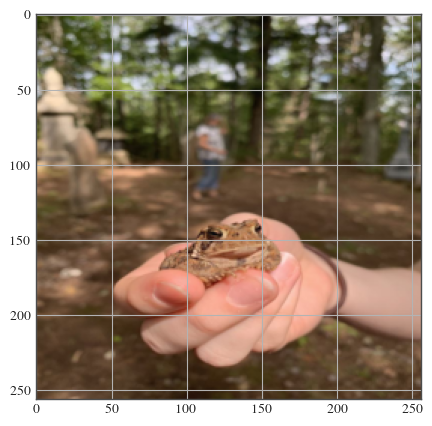

In [43]:
plt.imshow(dataset[4][0].permute(1, 2, 0))
plt.show()

In [44]:
np.random.seed(0)
indices = np.random.permutation(len(dataset))

train_ds = Subset(dataset, indices=indices[:14000])
test_ds = Subset(dataset, indices=indices[14000:])

In [73]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 17)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0, momentum=.9, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

for i in range(5):
    train_one_epoch(model, train_loader, criterion, optimizer, epoch=i, device='cuda', print_freq=10)


Epoch [0] [  0/219] eta: 0:03:47 lr: 0.01 loss: 2.8587 (2.8587) acc1: 6.2500 (6.2500) time: 1.0368 data: 0.7125 max mem: 7834
Epoch [0] [ 10/219] eta: 0:03:15 lr: 0.01 loss: 2.7344 (2.7411) acc1: 14.0625 (16.3352) time: 0.9362 data: 0.6431 max mem: 7834
Epoch [0] [ 20/219] eta: 0:03:03 lr: 0.01 loss: 2.5291 (2.5130) acc1: 31.2500 (30.2827) time: 0.9173 data: 0.6270 max mem: 7834
Epoch [0] [ 30/219] eta: 0:02:54 lr: 0.01 loss: 2.0059 (2.2313) acc1: 48.4375 (38.0040) time: 0.9154 data: 0.6242 max mem: 7834
Epoch [0] [ 40/219] eta: 0:02:46 lr: 0.01 loss: 1.3249 (1.9789) acc1: 59.3750 (43.9024) time: 0.9423 data: 0.6509 max mem: 7834
Epoch [0] [ 50/219] eta: 0:02:36 lr: 0.01 loss: 1.0882 (1.7800) acc1: 64.0625 (49.0196) time: 0.9352 data: 0.6439 max mem: 7834
Epoch [0] [ 60/219] eta: 0:02:27 lr: 0.01 loss: 0.8879 (1.6231) acc1: 71.8750 (53.1506) time: 0.9231 data: 0.6312 max mem: 7834
Epoch [0] [ 70/219] eta: 0:02:18 lr: 0.01 loss: 0.7896 (1.5074) acc1: 73.4375 (56.0739) time: 0.9300 data:

KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

model.eval()
all_logits = []
all_targets = []
for inputs, targets in tqdm(test_loader):
    with torch.no_grad():
        logits = model(inputs.to('cuda')).cpu()
    all_logits.append(logits)
    all_targets.append(targets)
logits = torch.cat(all_logits)
targets = torch.cat(all_targets)

100%|██████████| 9/9 [00:25<00:00,  2.80s/it]


In [75]:
(logits.argmax(-1) == targets).float().mean()

tensor(0.7794)

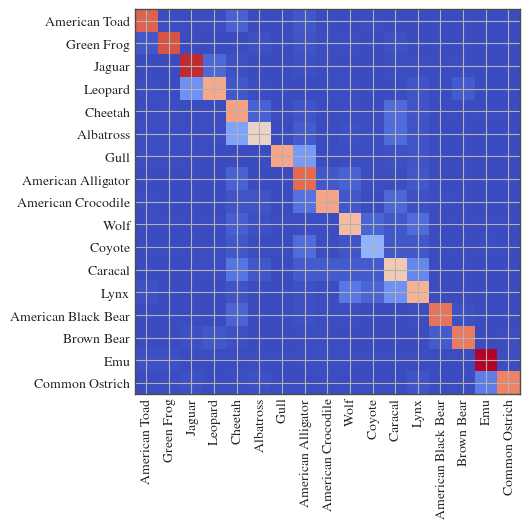

In [76]:
from sklearn.metrics import confusion_matrix

preds = logits.argmax(-1)
plt.xticks(range(0, 17), list(dataset.classid_to_classname.values()), rotation=90)
plt.yticks(range(0, 17), list(dataset.classid_to_classname.values()))
plt.imshow(confusion_matrix(targets, preds))
plt.show()